# DMD

## Setup

In [76]:
import numpy as np
import matplotlib.pyplot as plt

Primeiro, definimos algumas funções para teste.

Essas funções tem parte imaginária para demonstrar a capacidade do DMD de lidar com problemas complexos.

In [77]:
x = np.linspace( -10, 10, 200)
t = np.linspace(0, 4 * np.pi , 61)
dt = t[1] - t[0]

In [78]:
S, T = np.meshgrid(x, t)

In [79]:
# Criando os modos para testar o potencial de captura do DMD
# Essa primeira função é puramente espacial e real
X1 = 0.8 * np.sin(S) * (1 + 0 * T)
# Essa segunda função, por sua vez, é espaço-temporal e complexa
X2 = 1.0 / np.cosh(S + 3) * np.exp(2.5j * T)
# Nosso sinal de teste é a soma dessas duas funções
# Testaremos então a capacidade do DMD de capturar as duas funções
X = X1 + X2

In [80]:
X.T.shape

(200, 61)

São $61$ snapshots de dimensão $200$.

Antes de prosseguirmos, vamos visualizar nossos modos.

## Visualizações (pré-DMD)

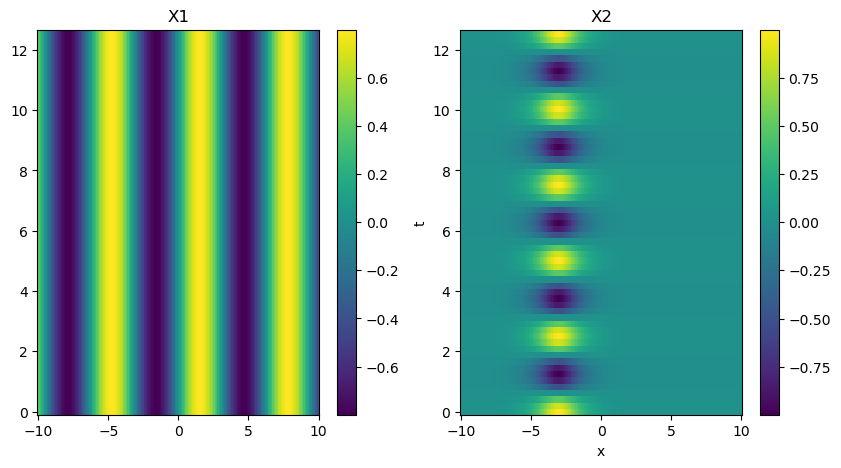

In [81]:
# Plot X1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pcolor(S, T, X1)
plt.colorbar()
plt.title('X1')
# Plot X2
plt.subplot(1, 2, 2)
plt.pcolor(S, T, X2.real)
plt.colorbar()
plt.title('X2')
# Show axis t
plt.xlabel('x')
plt.ylabel('t')
plt.show()

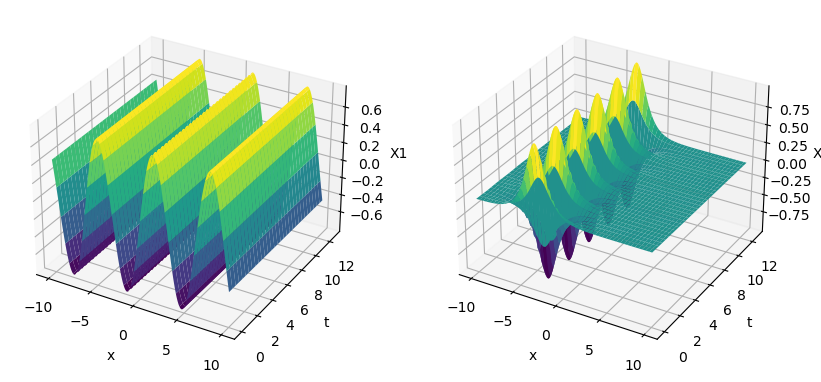

In [82]:
# Visualizando tridimensionalmente
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(S, T, X1, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('X1')
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(S, T, X2.real, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('X2')
plt.show()

## Aplicando o DMD

Antes mesmo de começar já temos uma peculiaridade em relação ao POD: vamos truncar os resulados do SVD baseado no posto aproximado $r$ da matriz $X$.

Em casos menos experimentais, seria correto aplicar um algoritmo para calcular este posto aproximado.
Contudo, como é sabido que ele guiará a quantidade de modos que o DMD identificará, vamos já estabelecer $r = 2$.

1. Fazendo o SVD da matriz de snapshots. Aqui não fazemos o SVD completo. Como sugere o algoritmo

In [ ]:
U, Sigma, Vh = np.linalg.svd(X, False)